In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import ConvexHull
from random import uniform
from IPython.display import clear_output
import os

from geom import distance, intersection, parallel, angle, orthogonal, Line, Plane, Point, solve, Vector

from funcs import Cube, Parallelepiped, WCCoPrism, RegularTriangularPrism
from funcs import area_of_triangle_3d, from_polygon_to_list_of_triangles, area_of_polygon_3d

In [2]:
#Новые функции которые надо будет добавить в funcs

def generate_point_in_triangle(A1, A2, A3):
    '''
    A1, A2, A3: Point or array - 2D/3D coordinates of triangle, where we generate a Point uniformly
    '''
    z = np.random.uniform(0., 1., 2)
    l1 = z[0]**0.5
    l2 = z[1]
    
    A1_ = np.array([A1[0], A1[1], A1[2]])
    A2_ = np.array([A2[0], A2[1], A2[2]])
    A3_ = np.array([A3[0], A3[1], A3[2]])
    
    P_new = (1-l1)*A1_ + l1*(1-l2)*A2_ + l1*l2*A3_
    return Point(P_new)


def is_point_in_polygon(P, polygon):
    '''
    check if point P is in polygon
    
    P: Point or np.darray
    polygon: np.darray of coordinates of polygon vertices
    
    return True if point is in polygon, False otherwise
    '''
    S = area_of_polygon_3d(polygon) #area of polygon
    S_ = 0 #area of triangles PAB, where A, B - neighbour points of polygon
    
    N_edges = len(polygon)
    for i in range(N_edges-1):
        S_ += area_of_triangle_3d([P, polygon[i], polygon[i+1]])
        
    S_ += area_of_triangle_3d([P, polygon[N_edges-1], polygon[0]])
    
    return abs(S-S_) < 0.0000001


def from_list_points_to_array(points):
    '''
    transform list of Points to array of 3D coordinates
    '''
    vecs = np.zeros((len(points), 3))
    for i in range(len(points)):
        vecs[i] = points[i][0], points[i][1], points[i][2]
    return vecs
    

def proportion_S(triangles):
    '''
    get array of proportion of triangles over the triangle
    
    triangles: list of triangles
    '''
    n_triangles = triangles.shape[0]
    proportions = np.zeros(n_triangles)
    
    for j in range(n_triangles):
        proportions[j] = area_of_triangle_3d(triangles[j])

    return proportions/proportions.sum()


def generations_point_in_polygon(vectors):
    '''
    generate point in polygon
    
    '''
    
    triangles = from_polygon_to_list_of_triangles(vectors)
    proportions = proportion_S(triangles)
    proportions_cumsum = np.cumsum(proportions) #to get prob of put point in one triangle
    
    num = np.random.uniform(0, 1)
    
    k = 0 #number of triangle
    for i in range(len(proportions_cumsum)):
        if num <= proportions_cumsum[i]:
            k = i
            break
    
    point = generate_point_in_triangle(triangles[k][0], triangles[k][1], triangles[k][2])
    return point


def test_generate_linear_intersept(cube=Cube()):
    '''
    возвращает список точек-проекций на плоскость и ее выпуклую оболочку
    '''
    #генерируем вектор нормали
    fi = 2*np.pi*uniform(0, 1)
    teta = np.arccos(2*uniform(0, 1) - 1)
    n = Vector(np.sin(teta)*np.cos(fi), 
               np.sin(teta)*np.sin(fi),
               np.cos(teta))
    
    #берем плоскость с таким вектором нормали и проходящую через 0.
    plane = Plane(Point(0., 0., 0.), n)
    #в этой плоскости надо найти многоугольник-проекцию всех точек куба
    polygon_points_not_ordered = []
    for M in cube.iterable_points:
        line_MP = Line(M, n)
        #P - projection of M on plane
        P = intersection(line_MP, plane)
        polygon_points_not_ordered.append([P[0], P[1], P[2]])
    
    polygon_points_not_ordered = np.array(polygon_points_not_ordered)
    hull = ConvexHull(polygon_points_not_ordered[:, :2])
    return polygon_points_not_ordered, hull

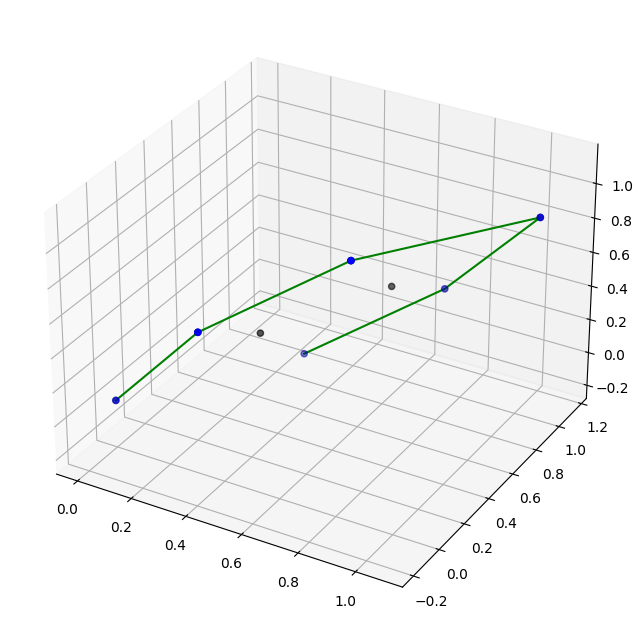

In [3]:
points, hull = test_generate_linear_intersept()

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='black')
ax.scatter(points[hull.vertices][:, 0], points[hull.vertices][:, 1], points[hull.vertices][:, 2], color='blue')
ax.plot(points[hull.vertices][:, 0], points[hull.vertices][:, 1], points[hull.vertices][:, 2], color='green')

### действительно выпуклая оболочка

In [4]:
def generate_linear_intersept(polyhedron=Cube()):
    '''
    generation of length of random linear intersept in polyhedron
    '''
    #генерируем вектор нормали
    fi = 2*np.pi*uniform(0, 1)
    teta = np.arccos(2*uniform(0, 1) - 1)
    n = Vector(np.sin(teta)*np.cos(fi), 
               np.sin(teta)*np.sin(fi),
               np.cos(teta))
    
    #берем плоскость с таким вектором нормали и проходящую через 0.
    plane = Plane(Point(0., 0., 0.), n)
    #в этой плоскости надо найти многоугольник-проекцию всех точек куба
    polygon_points_not_ordered = []
    for M in polyhedron.iterable_points: #проходимся по точкам куба
        line_MP = Line(M, n) #линия-нормаль - через точку куба, которую проецируем
        P = intersection(line_MP, plane) #P - projection of M on plane
        polygon_points_not_ordered.append([P[0], P[1], P[2]]) #добавим точку P в список точек-проекций
    
    polygon_points_not_ordered = np.array(polygon_points_not_ordered) 
    hull = ConvexHull(polygon_points_not_ordered[:, :2]) #берем выпуклую оболочку у проекции многоугольника на Oxy чтобы найти
                                                         #вершины, которые являются тем самым многоугольником-проекцией
    polygon = polygon_points_not_ordered[hull.vertices]  #оставляем только нужные вершины и в нужном порядке
    
    Pns = generations_point_in_polygon(polygon) #генерируем точку в этом многоугольнике-проекции
    linear_intersept_line = Line(Pns, n) # прямая, содержащая этот перехват, проходит через Pns и сонаправлена n
    
    two_points = [] #будем надеяться что будет две точки у концов отрезка
    #будем среди пересечений линии linear_intersept_line искать те, которые пересекают именно грани
    
    for i, pl in enumerate(polyhedron.iterable_planes):
        #check the intersection of generated line and a polyhedron's facets
        X = intersection(linear_intersept_line, pl)
        #need to check is the X inside the facet
        if is_point_in_polygon(X, from_list_points_to_array(polyhedron.iterable_facets[i])):
            two_points.append(X)
    if len(two_points) != 2:
        print('smth went wrong, not 2 points')
        return None
    P1 = two_points[0]
    P2 = two_points[1]
    lin = P1-P2
    
    return (lin[0]**2 + lin[1]**2 + lin[2]**2)**0.5

In [7]:
def norm_dict(char_dict, step):
    '''
    Нормирует характеристику, поданную словарём, чтобы получить из гистограммы плотность вероятности
    Например, на вход подается гистограмма площадей:
    (Nebo от 24.10)
    
    {0.00: 5,
     0.01: 10,
     ...}
    step = 0.01
    
    Нужно каждое значение из словаря поделить на норм. константу
    norm_const = step*(values.sum())
    
    '''
    norm_const = step*sum(char_dict.values())
    return {key: value/norm_const for key, value in char_dict.items()} #генератор списков


def extract_and_trim_dict(dictionary):
    keys = []
    values = []
    for key, value in dictionary.items():
        keys.append(key)
        values.append(value)

    # Обрезаем конец списков, пока последний элемент не равен 0.0
    while values and values[-1] == 0.0:
        del keys[-1]
        del values[-1]
    return keys, values

In [17]:
def calculate_linear_intercept(polyhedron, type_figure='parallelepiped', n=10000, params=None):
    
    #PATH = os.path.join(os.getcwd(), 'densities')

    try:
        os.mkdir('densities')
    except:
        pass


    #ПАРАЛЛЕЛЕПИПЕД
    if type_figure == 'parallelepiped':

        if params:
            a_side = params['side_a']
            b_side = params['side_b']
            c_side = params['side_c']
        else:
            a_side = 1.
            b_side = 2.
            c_side = 3.
            params = {'side_a': 1.,
                        'side_b': 2.,
                        'side_c': 3.}

        path_ = os.path.join("densities", f"parallelepiped_a={a_side}b={b_side}c={c_side}")

        try:
            intercept = np.load(os.path.join(path_, f'intercept_N={n}.npy'), allow_pickle=True).item()


        except:
            intercept_dict = {} #пустой словать с ключами от 0.00 до a^2+b^2+c^2 #можно меньше
            step = 0.01
            current_key = 0.00
            while current_key <= 10*(a_side**2 + b_side**2 + c_side**2):
                intercept_dict.setdefault(round(current_key, 2), 0)
                current_key += step

            num_errors = 0   


            for i in range(n):

                temp = generate_linear_intersept(polyhedron=polyhedron)
                if temp is not None:
                    intercept_dict[round(temp, 2)] += 1
                else:
                    num_errors += 1

            print('precision is ', 1-num_errors/n)

            intercept = norm_dict(intercept_dict, step=0.01)

            try:
                os.mkdir(path_)
            except:
                pass

            np.save(os.path.join(path_, f'intercept_N={n}.npy'), intercept)



    if type_figure == 'triangular prism':

        if params:
            side = params['side']
        else:
            side = 1.
            params = {'side': 1.}

        #path_ = PATH + r'\tri-prism_side=' + str(side)
        path_ = os.path.join("densities", f"tri-prism_side={side}")

        try:
            intercept = np.load(os.path.join(path_, f'intercept_N={n}.npy'), allow_pickle=True).item()

        except:
            intercept_dict = {} #пустой словать с ключами от 0.00 до a^2+b^2+c^2 #можно меньше
            step = 0.01
            current_key = 0.00
            while current_key <= 10*(side*side):
                intercept_dict.setdefault(round(current_key, 2), 0)
                current_key += step

            num_errors = 0   


            for i in range(n):
                temp = generate_linear_intersept(polyhedron=polyhedron)
                if temp is not None:
                    intercept_dict[round(temp, 2)] += 1
                else:
                    num_errors += 1

            print('precision is ', 1-num_errors/n)

            intercept = norm_dict(intercept_dict, step=0.01)

            try:
                os.mkdir(path_)
            except:
                pass

            np.save(os.path.join(path_, f'intercept_N={n}.npy'), intercept)





    if type_figure == 'hex prism':

        r = params['r']
        k = params['k']

        path_ = os.path.join("densities", f"hex-prism_r={r}k={k}")

        try:
            intercept = np.load(os.path.join(path_, f'intercept_N={n}.npy'), allow_pickle=True).item()

        except:
            intercept_dict = {} #пустой словать с ключами от 0.00 до a^2+b^2+c^2 #можно меньше
            step = 0.01
            current_key = 0.00
            while current_key <= 10.:
                intercept_dict.setdefault(round(current_key, 2), 0)
                current_key += step

            num_errors = 0   


            for i in range(n):
                temp = generate_linear_intersept(polyhedron=polyhedron)
                if temp is not None:
                    intercept_dict[round(temp, 2)] += 1
                else:
                    num_errors += 1

            print('precision is ', 1-num_errors/n)

            intercept = norm_dict(intercept_dict, step=0.01)

            try:
                os.mkdir(path_)
            except:
                pass

            np.save(os.path.join(path_, f'intercept_N={n}.npy'), intercept)


    return intercept

In [20]:
params = {"side": 2.0}
intercept = calculate_linear_intercept(RegularTriangularPrism(**params), 'triangular prism', n=10000, params=params)

smth went wrong, not 2 points
smth went wrong, not 2 points
precision is  0.9998


In [8]:
%%time
#28 minutes
np.random.seed(173)

a_side = 1.
b_side = 2.
c_side = 3.

polyhedron = Parallelepiped(a_side, b_side, c_side)

num_errors = 0
intercept_dict = {} #пустой словать с ключами от 0.00 до a^2+b^2+c^2 #можно меньше
step = 0.01
current_key = 0.00
while current_key <= 10*(a_side**2 + b_side**2 + c_side**2):
    intercept_dict.setdefault(round(current_key, 2), 0)
    current_key += step

for i in range(10000):
    temp = generate_linear_intersept(polyhedron=polyhedron)
    if temp is not None:
        intercept_dict[round(temp, 2)] += 1
    else:
        num_errors += 1

intercept_dict = extract_and_trim_dict(norm_dict(intercept_dict, step=0.01))
        

Wall time: 17.5 s


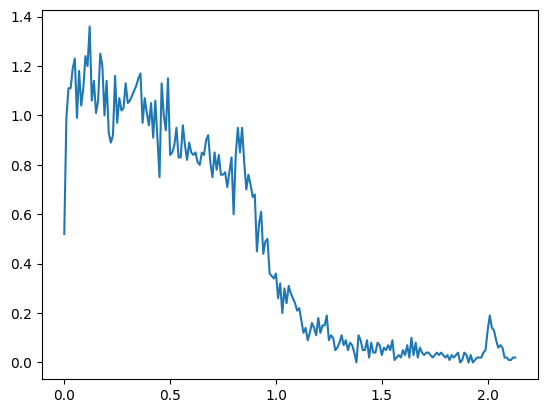

In [24]:
plt.plot(*extract_and_trim_dict(intercept))

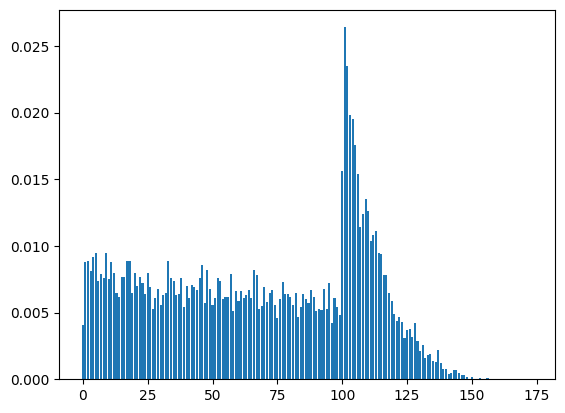

In [7]:
plt.bar(np.linspace(0, 173, 174), intersepts_cube/sum(intersepts_cube))

#x = np.array([0, 0.25, 0.5, 0.75, 1., 1.25, 1.5, 1.75])
#

#plt.savefig('intersepts_cube.jpg')